# Class Activation Map in Pytorch from Scratch
## with OxfordTPet dataset

*Code Writer: Chaeeun Ryu*

In [1]:
!nvidia-smi

Mon Mar 27 14:17:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1D:00.0 Off |                  N/A |
| 30%   33C    P5    37W / 350W |      5MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:1F:00.0 Off |                  N/A |
| 53%   

# Import Libraries

In [2]:
import argparse
import os
import random
import time
import warnings
import sys
import numpy as np
import torch
import torch.nn as nn 
import torchvision.transforms as transforms
from collections import Counter, OrderedDict
import torch.optim
from sklearn.metrics import confusion_matrix
from torchvision.datasets import OxfordIIITPet
import os
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import torchvision.models as models
import glob
import copy
# from torchvision.models import resnet50, ResNet50_Weights
import torchvision
import matplotlib.pyplot as plt
device =  torch.device('cuda:0')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

# Config

In [4]:
from dataclasses import dataclass
@dataclass
class ARGS():
    LR = 0.005
    EPOCHS = 300
    BATCHSIZE = 100
    MOMENTUM = 0.9
    WORKERS = 0
    WEIGHTDECAY = 0
    T_MAX = 150
    CLS_CLASS = 37
    SEG_CLASS = 3
    SIZE = 224
    SEED = 38
    DETACH = 120
    ETA_MIN = 0
    
args = ARGS()

In [5]:
seed_everything(args.SEED)

# Get dataset

In [6]:
transform_train = transforms.Compose([
        transforms.Resize((args.SIZE,args.SIZE)),
        transforms.RandomCrop(args.SIZE, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_val = transforms.Compose([
        transforms.Resize((args.SIZE,args.SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

In [7]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
_tr_transform = [
        A.Resize(height = args.SIZE, width = args.SIZE,p=1),
        A.Rotate(limit=30,p=0.3),
        A.ColorJitter(p=0.3),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
_val_transform = [
        A.Resize(height = args.SIZE, width = args.SIZE,p=1),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
to_tensor = A.Compose([ToTensorV2()])
seg_transform_train = A.Compose(_tr_transform)
seg_transform_val = A.Compose(_val_transform)

#### Datasets

In [8]:
classification_train_dataset = OxfordIIITPet(root='./data', split="trainval", target_types = 'category',download=True, transform=transform_train)
classification_val_dataset = OxfordIIITPet(root='./data', split="test", target_types = 'category',download=True, transform=transform_val)

In [9]:
_segmentation_train_dataset = OxfordIIITPet(root='./data', split="trainval", target_types = 'segmentation',download=True)
_segmentation_val_dataset = OxfordIIITPet(root='./data', split="test", target_types = 'segmentation', download=True)

In [10]:
from torch.utils.data import Dataset, DataLoader
class SegDataset(Dataset):
    def __init__(self, dataset, transform):
        self.tf = transform
        self.dataset = dataset
    
    def __len__(self):
        return self.dataset.__len__()
    
    def __getitem__(self, idx):
        img_tuple, mask_tuple = self.dataset.__getitem__(idx)
        sample = self.tf(image = np.array(img_tuple), mask= np.array(mask_tuple))
        img,mask = sample["image"],sample["mask"]
        mask[mask==2] = 0# convert background (prev: 2) as 0
        mask[mask == 3] = 2# convert outline (prev:3) as 2
        # class info
        # background: 0
        # object: 1
        # outline: 2
        return img,mask

In [11]:
segmentation_train_dataset = SegDataset(_segmentation_train_dataset,seg_transform_train)
segmentation_val_dataset = SegDataset(_segmentation_val_dataset,seg_transform_val)

#### Dataloaders

In [12]:
global classification_loaders
classification_loaders = dict()
classification_train_loader = torch.utils.data.DataLoader(
            classification_train_dataset, batch_size=args.BATCHSIZE, shuffle=True,
            num_workers=args.WORKERS, pin_memory=True)
classification_val_loader = torch.utils.data.DataLoader(
    classification_val_dataset, batch_size=args.BATCHSIZE, shuffle=False,
    num_workers=args.WORKERS, pin_memory=True)

classification_loaders['train_loader'] = classification_train_loader
classification_loaders['val_loader'] = classification_val_loader

# Basic Model

In [61]:
import copy
class BaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaseCNN,self).__init__()
        self.num_classes = num_classes
        first_out = 6
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=first_out,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(first_out)
        self.relu = nn.ReLU(inplace = True)
        self.avgpool1 = nn.AvgPool2d(kernel_size=3)   
        
        second_out = 15
        self.conv2 = nn.Conv2d(in_channels=first_out,out_channels=second_out,kernel_size=3,stride=1,padding=2)
        self.bn2 = nn.BatchNorm2d(second_out)
        self.relu2 = nn.ReLU(inplace = True)
        self.avgpool2 = nn.AvgPool2d(kernel_size = 3)
        
        third_out = 21
        self.conv3 = nn.Conv2d(in_channels=second_out, out_channels=third_out,kernel_size = 3, stride = 1,padding = 2)
        self.bn3 = nn.BatchNorm2d(third_out)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool3 = nn.AvgPool2d(kernel_size=3)
        
        fourth_out = 36
        self.conv4 = nn.Conv2d(in_channels=third_out, out_channels=fourth_out,kernel_size = 3, stride = 1,padding = 2)
        self.bn4 = nn.BatchNorm2d(fourth_out)
        self.relu4 = nn.ReLU(inplace=True)
        self.avgpool4 = nn.AvgPool2d(kernel_size=3)
        
        self.drop1 = nn.Dropout1d(0.5)
        self.GAP = nn.AdaptiveAvgPool2d((1,1))
        self.final_fc = nn.Linear(fourth_out,args.CLS_CLASS)
    def forward(self,x):
        x = self.conv1(x)
        #print("after conv1:",x.size())
        x = self.bn1(x)
        #print("after bn1:",x.size())
        x = self.relu(x)
        #print("after relu:",x.size())
        x = self.avgpool1(x)
        #print("after avgpool1:",x.size())
        
        x = self.conv2(x)
        #print("after conv2:",x.size())
        x = self.bn2(x)
        #print("after bn2:",x.size())
        x = self.relu2(x)
        #print("after relu2:",x.size())
        x = self.avgpool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.avgpool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.avgpool4(x)
        
        feature_map = x.clone()
        #print("after avgpool2:",x.size())
        x = self.GAP(x)
        #print("after GAP:",x.size())
        x = x.flatten(1)
        x = self.final_fc(x)
        return feature_map,x

In [67]:
cnn = BaseCNN(args.CLS_CLASS).to(device)

In [68]:
for name, param in cnn.named_parameters():
    if param.requires_grad:
        print(f"{name}")
        print(f"size: {param.size()}")

conv1.weight
size: torch.Size([6, 3, 3, 3])
conv1.bias
size: torch.Size([6])
bn1.weight
size: torch.Size([6])
bn1.bias
size: torch.Size([6])
conv2.weight
size: torch.Size([15, 6, 3, 3])
conv2.bias
size: torch.Size([15])
bn2.weight
size: torch.Size([15])
bn2.bias
size: torch.Size([15])
conv3.weight
size: torch.Size([21, 15, 3, 3])
conv3.bias
size: torch.Size([21])
bn3.weight
size: torch.Size([21])
bn3.bias
size: torch.Size([21])
conv4.weight
size: torch.Size([36, 21, 3, 3])
conv4.bias
size: torch.Size([36])
bn4.weight
size: torch.Size([36])
bn4.bias
size: torch.Size([36])
final_fc.weight
size: torch.Size([37, 36])
final_fc.bias
size: torch.Size([37])


# Basic Training

In [69]:
optimizer = torch.optim.Adam(cnn.parameters(),lr=0.05)
criterion = nn.CrossEntropyLoss()

In [70]:
cnn.train()

BaseCNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (avgpool1): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (conv2): Conv2d(6, 15, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (avgpool2): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (conv3): Conv2d(15, 21, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (avgpool3): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (conv4): Conv2d(21, 36, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU(inplace=True)
  (avgpool4): AvgPool2d(kernel_s

In [71]:
import copy
best_acc = 0.
max_patience= 3
for epoch in range(30):
    epoch_loss = []
    save_acc = []
    for image_batch,label_batch in classification_loaders['train_loader']:
        image_batch,label_batch = image_batch.to(device),label_batch.to(device)
        _,out = cnn(image_batch)
        preds = out.argmax(dim = 1)
        loss = criterion(out,label_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss.append(loss.item())
        save_acc.append((torch.sum((preds==label_batch)*1)/preds.size()[0]).item())
    print("loss:",np.mean(epoch_loss))
    print("acc:",np.mean(save_acc))
    if np.mean(save_acc)>best_acc:
        best_acc = np.mean(save_acc)
        best_model = copy.deepcopy(cnn)
        patience= 0
    else:#drop lr
        for g in optimizer.param_groups:
            g['lr'] /= 2
            print(f"reducing lr to {g['lr']}...")
            patience+=1
    if patience > max_patience:
        print("early stopping..")
        break
print("train ended")

loss: 3.6212900135968185
acc: 0.033310809978158086
loss: 3.5512043592092155
acc: 0.048513512051588784
loss: 3.507281496718123
acc: 0.057905403997849776
loss: 3.4514166857745194
acc: 0.07189189018429937
loss: 3.373070768407873
acc: 0.08635134974846968
loss: 3.3435373306274414
acc: 0.09243243016503952
loss: 3.3010054343455546
acc: 0.1008108073996531
loss: 3.2740286878637366
acc: 0.10810810549033655
loss: 3.2548249669977136
acc: 0.10351351059570506
reducing lr to 0.025...
loss: 3.1950143479012154
acc: 0.12912161759025342
loss: 3.163253945273322
acc: 0.1293243212071625
loss: 3.1391274284672095
acc: 0.13243242927096985
loss: 3.114798184987661
acc: 0.1458108066707044
loss: 3.0971610223924793
acc: 0.14797296858317144
loss: 3.0891703528326913
acc: 0.1391216181218624
reducing lr to 0.0125...
loss: 3.039825542553051
acc: 0.15222972631454468
loss: 3.02516347653157
acc: 0.1565540499381117
loss: 3.010699852092846
acc: 0.1547297259440293
reducing lr to 0.00625...
loss: 2.9797006684380607
acc: 0.1652

In [72]:
print(f"best acc: {best_acc} acc by random: {1/args.CLS_CLASS}")

best acc: 0.18810810209126086 acc by random: 0.02702702702702703


# Draw CAM for one batch

In [91]:
input_batch,label_batch = next(iter(classification_loaders['train_loader']))
input_batch,label_batch = input_batch.to(device),label_batch.to(device)
feature_maps,out = best_model(input_batch)
W,b = list(best_model.final_fc.parameters())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


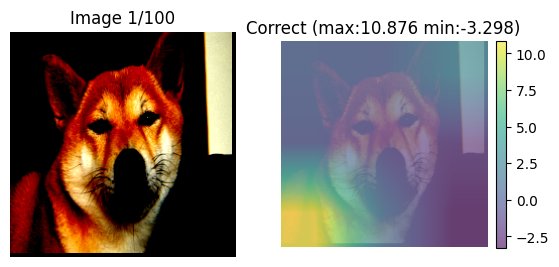

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


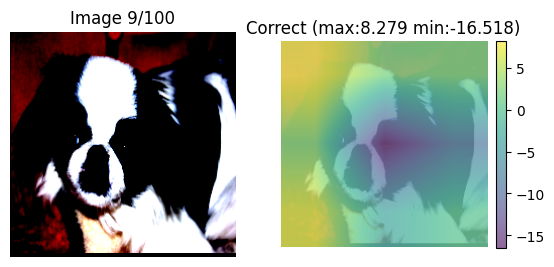

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


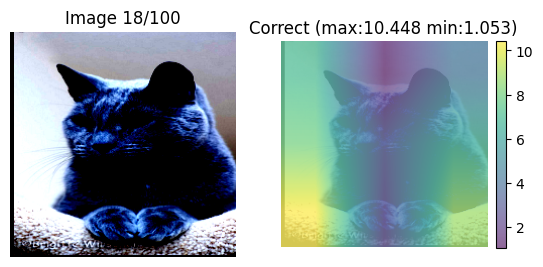

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


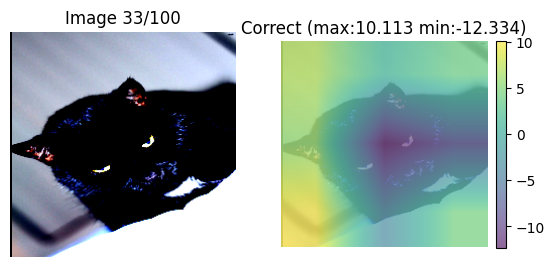

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


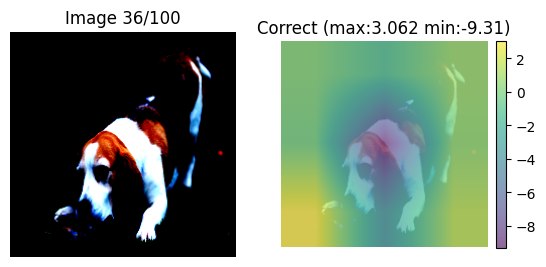

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


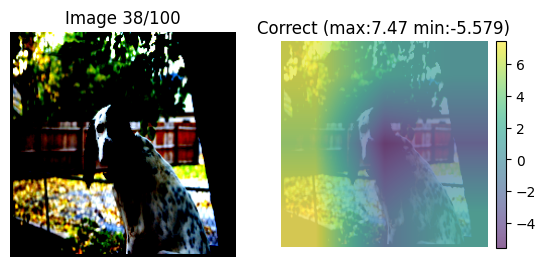

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


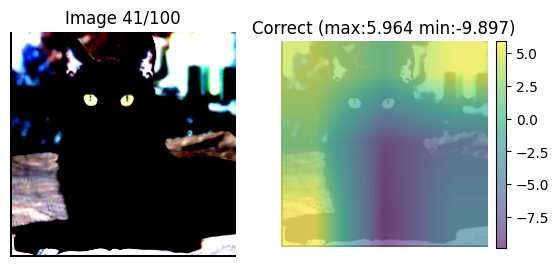

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


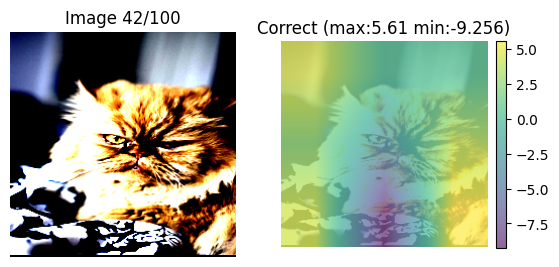

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


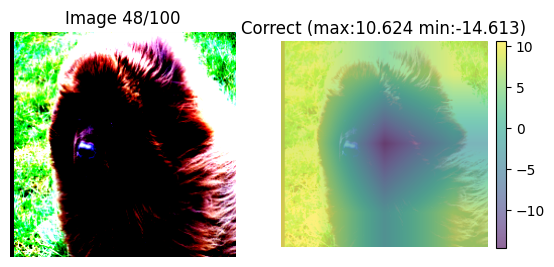

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


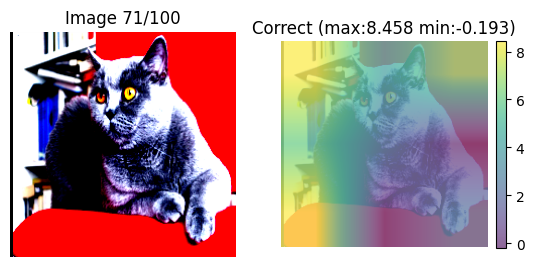

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


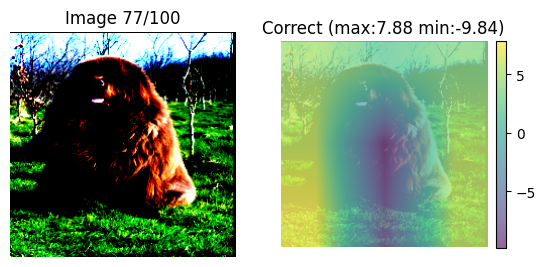

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


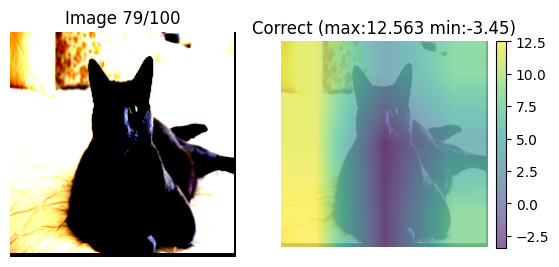

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


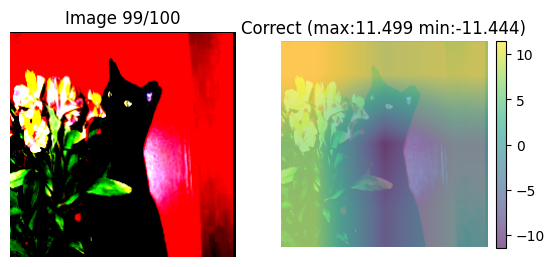

In [92]:
expand_tr = transforms.Resize((224,224))
for idx in range(args.BATCHSIZE):    
    use_img,use_label,use_feature_map,use_out = input_batch[idx],label_batch[idx],feature_maps[idx],out[idx]
    pred = torch.argmax(use_out).item()
    correction = 'Correct' if pred == use_label.item() else 'Wrong'
    class_idx = 0
    if correction == 'Correct':
        for map,w in zip(use_feature_map,W.T):
            if class_idx == 0:
                total_cam = map*w[class_idx]
            else:
                total_cam += map*w[class_idx]
            class_idx +=1
        plt.subplot(121)
        plt.title(f"Image {idx}/{args.BATCHSIZE}")
        plt.axis('off')
        plt.imshow(use_img.permute(1,2,0).detach().cpu().numpy())
        plt.subplot(122)
        expanded_cam = expand_tr(total_cam.unsqueeze(0))

        plt.title(f'{correction} (max:{round(torch.max(expanded_cam).item(),3)} min:{round(torch.min(expanded_cam).item(),3)})')
        plt.axis('off')
        plt.imshow(use_img.permute(1,2,0).detach().cpu().numpy(),alpha = 0.4)
        im = plt.imshow(expanded_cam[0].detach().cpu().numpy(),alpha = 0.6)
        plt.colorbar(im,fraction=0.046, pad=0.04)
        plt.show()
